## Explore SYNTHEA data in the OMOP schema 

## Develop our cohort

In [78]:
#import all the packages
import psycopg2
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## import all the packages you need 
import psycopg2
#from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay
import matplotlib as mpl
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
import missingno as msno

In [2]:
hostname = "spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com"
username = "introml568"
password = "m7bxMRtyMqPbcxyRRGML8"
database_name = "mimic"

In [3]:
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)
db_connection = alchemy_engine.connect();

In [4]:
omop_person = pd.read_sql("select * from omop.person", db_connection);
omop_visit = pd.read_sql("select * from omop.visit_occurrence", db_connection);

In [5]:
omop_visit.head()

,visit_occurrence_id,person_id,visit_concept_id,visit_start_date,visit_start_datetime,visit_end_date,visit_end_datetime,visit_type_concept_id,provider_id,care_site_id,visit_source_value,visit_source_concept_id,admitting_source_concept_id,admitting_source_value,discharge_to_concept_id,discharge_to_source_value,preceding_visit_occurrence_id,admitting_concept_id,discharge_to_source_concept_id
0,213,392776072,9201,2138-07-17,2138-07-17 19:04:00,2138-07-21,2138-07-21 15:48:00,44818518,None,397812313,NEWBORN,2001047001,2001046997,PHYS REFERRAL/NORMAL DELI,8536,HOME,NaN,8940,2001051946
1,214,392776073,262,2101-10-20,2101-10-20 17:09:00,2101-10-31,2101-10-31 13:58:00,44818518,None,397812313,EMERGENCY,2001047000,2001046993,EMERGENCY ROOM ADMIT,8863,SNF,NaN,8870,2001051954
2,215,392776074,262,2191-03-15,2191-03-15 13:10:00,2191-03-23,2191-03-23 18:41:00,44818518,None,397812313,EMERGENCY,2001047000,2001046993,EMERGENCY ROOM ADMIT,8536,HOME WITH HOME IV PROVIDR,NaN,8870,2001051948
3,216,392776075,9201,2103-02-02,2103-02-02 04:31:00,2103-02-04,2103-02-04 12:15:00,44818518,None,397812313,NEWBORN,2001047001,2001046997,PHYS REFERRAL/NORMAL DELI,8536,HOME,NaN,8940,2001051946
4,217,392776076,9201,2175-05-30,2175-05-30 07:15:00,2175-06-15,2175-06-15 16:00:00,44818518,None,397812313,ELECTIVE,2001046999,2001046997,PHYS REFERRAL/NORMAL DELI,8536,HOME HEALTH CARE,NaN,8940,2001051947


## Start to derive required columns

In [5]:
#def person_age(birthdate):
#    """
#    defines age based on current date
#   """
#   difference_in_years = relativedelta(datetime.now(), birthdate).years
#   return difference_in_years

#omop_person['current_age'] = omop_person.birth_datetime.apply(person_age)

In [10]:
#inner join two tables
df = pd.merge(omop_person, omop_visit, on='person_id', how="inner")
col_keep = ['person_id', 'visit_occurrence_id', 'visit_start_date', 'visit_end_date', 'visit_start_datetime','visit_end_datetime', 'birth_datetime', 
            'gender_source_value', 'race_source_value', 'ethnicity_source_value']
df = df[col_keep]

In [11]:
df['age_at_visit'] = df.apply(lambda x: relativedelta(x['visit_start_datetime'], x['birth_datetime']).years, axis=1)
df['visit_length'] = df.apply(lambda x: relativedelta(x['visit_end_datetime'], x['visit_start_datetime']).hours, axis=1)
df.rename(columns={'gender_source_value': 'gender_concept_ID', 'race_source_value': 'race', 'ethnicity_source_value': 'ethnicity'}, inplace=True)
df.head(10)

,person_id,visit_occurrence_id,visit_start_date,visit_end_date,visit_start_datetime,visit_end_datetime,birth_datetime,gender_concept_ID,race,ethnicity,age_at_visit,visit_length
0,392820410,49790,2132-01-27,2132-02-02,2132-01-27 13:35:00,2132-02-02 11:40:00,2065-01-28,M,AMERICAN INDIAN/ALASKA NATIVE,None,66,22
1,392779593,3823,2150-01-08,2150-01-14,2150-01-08 10:15:00,2150-01-14 17:56:00,2117-09-03,F,AMERICAN INDIAN/ALASKA NATIVE,None,32,7
2,392800801,30456,2165-02-11,2165-02-13,2165-02-11 15:22:00,2165-02-13 19:08:00,2165-02-11,F,AMERICAN INDIAN/ALASKA NATIVE,None,0,3
3,392810738,47316,2111-04-01,2111-04-10,2111-04-01 17:55:00,2111-04-10 12:57:00,2070-08-26,M,AMERICAN INDIAN/ALASKA NATIVE,None,40,19
4,392779126,3077,2136-02-24,2136-03-25,2136-02-24 15:10:00,2136-03-25 14:10:00,2136-02-24,M,AMERICAN INDIAN/ALASKA NATIVE,None,0,23
5,392780371,5967,2153-06-06,2153-06-13,2153-06-06 21:31:00,2153-06-13 21:30:00,2153-06-06,M,AMERICAN INDIAN/ALASKA NATIVE,None,0,23
6,392780371,5968,2153-06-15,2153-06-19,2153-06-15 11:12:00,2153-06-19 14:00:00,2153-06-06,M,AMERICAN INDIAN/ALASKA NATIVE,None,0,2
7,392800654,29229,2146-01-28,2146-02-18,2146-01-28 15:13:00,2146-02-18 14:45:00,2146-01-28,M,AMERICAN INDIAN/ALASKA NATIVE,None,0,23
8,392794301,20659,2108-09-04,2108-09-10,2108-09-04 11:00:00,2108-09-10 13:30:00,2059-04-11,M,AMERICAN INDIAN/ALASKA NATIVE,None,49,2
9,392804824,32038,2156-06-01,2156-06-04,2156-06-01 10:00:00,2156-06-04 19:10:00,2093-05-29,M,AMERICAN INDIAN/ALASKA NATIVE,None,63,9


In [49]:
print(df)

       person_id  visit_occurrence_id visit_start_date visit_end_date  \
0      392820410                49790       2132-01-27     2132-02-02   
1      392779593                 3823       2150-01-08     2150-01-14   
2      392800801                30456       2165-02-11     2165-02-13   
3      392810738                47316       2111-04-01     2111-04-10   
4      392779126                 3077       2136-02-24     2136-03-25   
...          ...                  ...              ...            ...   
58971  392796781                39518       2173-12-08     2173-12-22   
58972  392800279                43831       2114-06-04     2114-06-15   
58973  392788217                14038       2161-02-19     2161-02-23   
58974  392802720                38477       2193-08-23     2193-08-27   
58975  392807535                47532       2146-10-31     2146-11-15   

      visit_start_datetime  visit_end_datetime birth_datetime  \
0      2132-01-27 13:35:00 2132-02-02 11:40:00     2065-01

## Inclusion Criteria

In [12]:
#people alive
# death = pd.read_sql("select * from omop.death", db_connection);
# df_alive = df[~df['person_id'].isin(death['person_id'])]

In [65]:
#filter age 18 - 30
df_age = df[(df['age_at_visit'] >= 50) & (df['age_at_visit'] <= 75)]

In [66]:
df_sorted = df_age.sort_values(by=['person_id', 'visit_start_date'])
df_limited_visits = df_sorted.groupby('person_id').head(20)

In [70]:
print(df_limited_visits)

       person_id  visit_occurrence_id visit_start_date visit_end_date  \
39586  392775850                  541       2149-12-17     2149-12-31   
39589  392775853                  546       2133-03-31     2133-04-23   
39590  392775853                  547       2133-08-15     2133-08-19   
17103  392775861                  559       2153-09-25     2153-09-28   
39600  392775862                  560       2160-01-09     2160-01-21   
...          ...                  ...              ...            ...   
27186  392822363                37287       2112-05-22     2112-05-25   
27187  392822363                37288       2112-05-28     2112-06-07   
10849  392822364                37289       2115-07-25     2115-07-30   
27191  392822368                37293       2129-01-03     2129-01-11   
27192  392822369                37294       2149-06-08     2149-06-23   

      visit_start_datetime  visit_end_datetime birth_datetime  \
39586  2149-12-17 11:10:00 2149-12-31 14:55:00     2075-03

## Combine Conditioning and Measurement with concept

In [15]:

omop_concept = pd.read_sql("select * from omop.concept", db_connection);
omop_condition = pd.read_sql("select * from omop.condition_occurrence", db_connection);

In [31]:
#condition - hypertension
df_condition = pd.merge(omop_condition, omop_concept[['concept_id', 'concept_name']], left_on='condition_concept_id', right_on='concept_id')

In [35]:
df_condition.head()

,condition_occurrence_id,person_id,condition_concept_id,condition_start_date,condition_start_datetime,condition_end_date,condition_end_datetime,condition_type_concept_id,stop_reason,provider_id,visit_occurrence_id,visit_detail_id,condition_source_value,condition_source_concept_id,condition_status_source_value,condition_status_concept_id,concept_id,concept_name
0,335970881,392783158,37116442,2170-01-30,2170-01-30 14:25:00,2170-02-13,2170-02-13 16:50:00,38000184,None,None,5509,None,56202,44837175.0,None,None,37116442,Diverticulosis of small intestine with hemorrhage
1,336090480,392793389,37116442,2178-03-14,2178-03-14 09:15:00,2178-03-18,2178-03-18 13:13:00,38000184,None,None,20988,None,56202,44837175.0,None,None,37116442,Diverticulosis of small intestine with hemorrhage
2,336350383,392800181,37116442,2195-01-21,2195-01-21 15:08:00,2195-01-26,2195-01-26 14:40:00,38000184,None,None,46752,None,56202,44837175.0,None,None,37116442,Diverticulosis of small intestine with hemorrhage
3,335996929,392787644,37116442,2152-02-28,2152-02-28 21:53:00,2152-03-05,2152-03-05 11:43:00,38000184,None,None,16341,None,56202,44837175.0,None,None,37116442,Diverticulosis of small intestine with hemorrhage
4,336349499,392807417,37116442,2182-08-17,2182-08-17 09:29:00,2182-08-22,2182-08-22 19:50:00,38000184,None,None,45566,None,56202,44837175.0,None,None,37116442,Diverticulosis of small intestine with hemorrhage


In [26]:
print(df_condition['condition_status_source_value'].unique())

[None]


In [20]:
Cholesterol_concepts = df_condition[df_condition['concept_name'].str.contains('Cholesterol', case=False, na=False)]

In [68]:

# Step 1: Filter the conditions DataFrame to get rows that relate to Type 2 diabetes mellitus
type_2_diabetes_concepts = df_condition[df_condition['concept_name'].str.contains('Type 2 diabetes mellitus', case=False, na=False)]

# Step 2: Merge this with your main DataFrame on person_id
merged_df = pd.merge(df_limited_visits, type_2_diabetes_concepts[['person_id', 'concept_name']], on='person_id', how='left')

# Step 3: Add a column to `df_merge` that indicates the presence of 'Type 2 diabetes mellitus'
merged_df['condition - Type 2 diabetes'] = merged_df['concept_name'].apply(lambda x: 'Presence' if pd.notnull(x) and 'type 2 diabetes mellitus' in x.lower() else 'Absence')

# Now, merged_df has a new column 'condition - Type 2 diabetes' with the presence or absence of the condition
print(merged_df[['person_id', 'condition - Type 2 diabetes']].head())




   person_id condition - Type 2 diabetes
0  392775850                     Absence
1  392775853                     Absence
2  392775853                     Absence
3  392775861                     Absence
4  392775862                     Absence


In [120]:
merged_df.to_csv('C:/Users/12862/OneDrive/Desktop/Yale HW/output.csv', index=False)

In [69]:
print(merged_df['condition - Type 2 diabetes'].value_counts())

condition - Type 2 diabetes
Absence     24532
Presence     1276
Name: count, dtype: int64


In [22]:
print(diabetes_concepts['concept_name'].unique())

['Type 1 diabetes mellitus'
 'Peripheral vascular disorder due to diabetes mellitus'
 'Renal disorder associated with type 1 diabetes mellitus'
 'Type 2 diabetes mellitus'
 'Nervous system disorder due to diabetes mellitus'
 'Kidney disorder due to diabetes mellitus' 'Secondary diabetes mellitus'
 'Diabetes mellitus without complication'
 'Neurological disorder with type 1 diabetes mellitus'
 'Hyperosmolar coma associated with diabetes mellitus'
 'Peripheral circulatory disorder associated with type 1 diabetes mellitus'
 'Coma associated with diabetes mellitus'
 'Disorder of eye with type 1 diabetes mellitus'
 'Type 1 diabetes mellitus with hyperosmolar coma'
 'Diabetes mellitus in mother complicating pregnancy, childbirth AND/OR puerperium'
 'Type 1 diabetes mellitus without complication'
 'Type 1 diabetes mellitus uncontrolled'
 'Diabetes mellitus during pregnancy - baby delivered'
 'Diabetes insipidus' 'Eye disorder due to diabetes mellitus'
 'Neonatal diabetes mellitus' 'Nephrogeni

In [7]:
csv_file_path = r'C:\Users\12862\OneDrive\Documents\GitHub\BIS568-final-project\BIS568-final-project\measurement\measurement.csv'

# Read the CSV file into a pandas DataFrame
df_measurement = pd.read_csv(csv_file_path)

# Show the first few rows of the DataFrame
print(df_measurement.head())

   measurement_concept_id  visit_occurrence_id          value_source_value
0                       0              31859.0           Adequate lighting
1                       0              31859.0           Adequate lighting
2                       0              31859.0         Bed alarm activated
3                       0              31859.0  Bed locked in low position
4                       0              31859.0           Family at bedside


In [8]:
#remove no matching data concept
df_measurement_filtered = df_measurement[df_measurement['measurement_concept_id'] != 0]

In [109]:
#including measure #1
df_meas = pd.merge(df_measurement_filtered, omop_concept[['concept_id', 'concept_name']], left_on='measurement_concept_id', right_on='concept_id')
meas_keep = ['visit_occurrence_id', 'concept_name', 'value_source_value']
df_meas = df_meas[meas_keep]

In [138]:
unique_concept_names = df_meas['concept_name'].unique()

# If you want to convert it to a list
unique_concept_names_list = list(unique_concept_names)

# Print the unique concept names
print(unique_concept_names_list)

['Left ventricular Cardiac index', 'Left ventricular Cardiac output', 'Left ventricular Stroke volume index', 'Stroke Volume Variation', 'Left ventricular Stroke volume', 'Systemic vascular Resistance index', 'Intracranial pressure (ICP)', 'Level of arousal', 'Oxygen saturation in Arterial blood', 'Systolic blood pressure', 'Oxygen gas flow Oxygen delivery system', 'Mean blood pressure', 'Bowel sounds', 'Cerebral perfusion pressure', 'Central venous pressure (CVP)', 'Resuscitation status', 'Dialysis', 'Glasgow coma score eye opening', 'Inhaled oxygen concentration', 'Glasgow coma scale', 'Heart rate', 'Heart rate rhythm', 'Respiratory rate', 'Line 1', 'Line 2', 'Line 3', 'Line 4', 'Line 5', 'Line 6', 'Line 7', 'Line 8', 'Mean pressure Respiratory system airway Calculated', 'Volume expired per minute Respiratory system', 'Glasgow coma score motor', 'Oxygen delivery', 'Pain severity - Reported', 'Pulmonary artery Mean blood pressure', 'PEEP Respiratory system', 'Pressure max Respiratory 

In [134]:
df_group = df_meas.groupby(['visit_occurrence_id','concept_name']).agg(group_value=('value_source_value',lambda x: list(x))).reset_index()

In [135]:
df_group.head()

,visit_occurrence_id,concept_name,group_value
0,1.0,Acetaminophen [Presence] in Serum or Plasma,[NEG]
1,1.0,Alanine aminotransferase [Enzymatic activity/v...,[19]
2,1.0,Alkaline phosphatase [Enzymatic activity/volum...,[75]
3,1.0,Amphetamines [Presence] in Urine,[NEG]
4,1.0,Amylase [Enzymatic activity/volume] in Serum o...,[37]


In [136]:
df_pivot = df_group.pivot(index='visit_occurrence_id',columns='concept_name',values='group_value').reset_index()

In [154]:
diabetes_features = [
    'Glucose [Mass/volume] in Blood',
    'Hemoglobin A1c/Hemoglobin.total in Blood',
    'Creatinine [Mass/volume] in Serum or Plasma',
    'Urea nitrogen [Mass/volume] in Serum or Plasma',
    'Sodium [Moles/volume] in Serum or Plasma',
    'Potassium [Moles/volume] in Serum or Plasma',
    'Chloride [Moles/volume] in Serum or Plasma',
    'Calcium [Moles/volume] in Serum or Plasma',
    'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma',
    'Bilirubin.total [Mass/volume] in Serum or Plasma',
    'Albumin [Mass/volume] in Serum or Plasma',
    'Protein [Mass/volume] in Serum or Plasma',
    'Hematocrit [Volume Fraction] of Blood by Automated count',
    'Hemoglobin [Mass/volume] in Blood',
    'Platelets [#/volume] in Blood by Automated count',
    'Lymphocytes [#/volume] in Blood',
    'Leukocytes [#/volume] in Blood',
    'C reactive protein [Mass/volume] in Serum or Plasma',
    'Body weight',
    'Body height',
    'Body temperature',
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Mean blood pressure',
    'Heart rate',
    'Oxygen saturation in Arterial blood',
    'Cholesterol [Mass/volume] in Serum or Plasma',
    'Triglyceride [Mass/volume] in Serum or Plasma --12 hours fasting' ,
    'Cholesterol in HDL [Mass/volume] in Serum or Plasma',
    'Cholesterol in LDL [Mass/volume] in Serum or Plasma by Direct assay',
    'Natriuretic peptide.B prohormone N-Terminal [Mass/volume] in Serum or Plasma',
    'Erythrocyte distribution width [Ratio] by Automated count',
    'MCV [Entitic volume] by Automated count',
    'Protein/Creatinine [Mass Ratio] in Urine',
    'Urine output',
    'Urate [Mass/volume] in Serum or Plasma',
    'Urate [Mass/volume] in Urine',
    'pH of Urine by Test strip',
    'Protein [Mass/volume] in Urine by Test strip',
    'Nitrite [Presence] in Urine by Test strip',
    'Ketones [Mass/volume] in Urine by Test strip',
    'Bicarbonate [Moles/volume] in Serum or Plasma',
    'Carbon dioxide, total [Moles/volume] in Blood by calculation',
    'Oxygen/Inspired gas setting [Volume Fraction] Ventilator',
    'Respiratory rate',
    'Tidal volume Ventilator --on ventilator',
    'Fibrin+Fibrinogen fragments [Mass/volume] in Platelet poor plasma',
    'Glasgow coma score eye opening',
    'Glasgow coma score motor',
    'Glasgow coma score verbal',
    'Glasgow coma scale',
    'Pain severity - Reported',
    'Pain assessment',
    'Pain management',
    'Eosinophils [#/volume] in Blood',
    'Monocytes [#/volume] in Blood by Automated count',
    'Nucleated erythrocytes [#/volume] in Blood by Manual count',
    'Prothrombin time (PT)',
    'aPTT in Blood by Coagulation assay',
    'Lactate [Moles/volume] in Blood',
    'Lactate dehydrogenase [Enzymatic activity/volume] in Serum or Plasma',
    'Erythrocytes [#/volume] in Blood by Automated count',
    'Basophils [#/volume] in Blood by Automated count',
    'Band form neutrophils [#/volume] in Blood',
    'Thyrotropin [Units/volume] in Serum or Plasma',
    'Thyroxine (T4) [Mass/volume] in Serum or Plasma',
    'Thyroxine (T4) free [Mass/volume] in Serum or Plasma',
    'Cortisol [Mass/volume] in Serum or Plasma',
    'Calcidiol [Mass/volume] in Serum or Plasma',
    'Testosterone [Mass/volume] in Serum or Plasma',
    'Estradiol (E2) [Mass/volume] in Serum or Plasma',
    'Carcinoembryonic Ag [Mass/volume] in Serum or Plasma',
    'Cancer Ag 125 [Units/volume] in Serum or Plasma',
    'Prostate specific Ag [Mass/volume] in Serum or Plasma',
    'Iron [Mass/volume] in Serum or Plasma',
    'Ferritin [Mass/volume] in Serum or Plasma',
    'Folate [Mass/volume] in Serum or Plasma',
    'Magnesium [Moles/volume] in Serum or Plasma',
    'Phosphate [Mass/volume] in Serum or Plasma',
    'Calcium.ionized [Moles/volume] in Blood',
    'visit_occurrence_id'
]

# Now you can use this list to filter your DataFrame 'df_pivot' to contain only these features
df_pivot_filtered = df_pivot[diabetes_features]


In [155]:
df_selected = pd.merge(merged_df, df_pivot_filtered, on='visit_occurrence_id', how='left')

In [156]:
df_selected.head()

,person_id,visit_occurrence_id,visit_start_date,visit_end_date,visit_start_datetime,visit_end_datetime,birth_datetime,gender_concept_ID,race,ethnicity,...,Estradiol (E2) [Mass/volume] in Serum or Plasma,Carcinoembryonic Ag [Mass/volume] in Serum or Plasma,Cancer Ag 125 [Units/volume] in Serum or Plasma,Prostate specific Ag [Mass/volume] in Serum or Plasma,Iron [Mass/volume] in Serum or Plasma,Ferritin [Mass/volume] in Serum or Plasma,Folate [Mass/volume] in Serum or Plasma,Magnesium [Moles/volume] in Serum or Plasma,Phosphate [Mass/volume] in Serum or Plasma,Calcium.ionized [Moles/volume] in Blood
0,392775850,541,2149-12-17,2149-12-31,2149-12-17 11:10:00,2149-12-31 14:55:00,2075-03-13,F,WHITE,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1.5, 1.5, 2.0, 2.9, 2.8, 2.2, 2.2, 1.9, 1.8, ...","[2.9, 2.7, 3.3, 3.4, 2.7, 6.8, 6.0, 4.7, 4.0]","[1.14, 1.20, 1.21, 1.14, 1.24]"
1,392775853,546,2133-03-31,2133-04-23,2133-03-31 03:58:00,2133-04-23 15:00:00,2078-03-06,M,WHITE,None,...,NaN,NaN,NaN,NaN,[84],[816],NaN,"[1.8, 1.9, 1.2, 1.8, 1.6, 1.7, 1.5, 2.0, 1.5, ...","[3.7, 2.4, 5.2, 3.1, 2.6, 3.3, 2.7, 3.2, 2.9, ...","[1.03, 1.02, 1.07, 1.15, 1.13, 1.15, 1.19]"
2,392775853,547,2133-08-15,2133-08-19,2133-08-15 01:42:00,2133-08-19 17:30:00,2078-03-06,M,WHITE,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1.6, 1.7, 1.8, 1.6]","[3.7, 3.5, 3.5, 3.4]",NaN
3,392775861,559,2153-09-25,2153-09-28,2153-09-25 18:01:00,2153-09-28 18:48:00,2090-01-05,M,UNKNOWN/NOT SPECIFIED,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1.9, 2.4, 1.9, 2.0]","[1.9, 2.3]",NaN
4,392775862,560,2160-01-09,2160-01-21,2160-01-09 11:42:00,2160-01-21 16:15:00,2104-06-18,M,WHITE,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1.7, 1.9, 1.8, 1.6, 1.7, 1.7, 1.9, 1.8, 1.9, ...","[3.5, 3.6, 3.9, 2.9, 2.6, 3.1, 3.2, 3.3, 3.2, ...",NaN


In [159]:


def expand_lists_in_dataframe(df, list_columns):
    # List to hold the dictionaries
    rows_list = []
    
    # Iterate over each row in the original DataFrame
    for idx, row in df.iterrows():
        # Find the maximum length of lists in this row for the specified columns
        max_length = max(len(row[col]) if isinstance(row[col], list) else 0 for col in list_columns)
        
        # Create new rows based on the maximum length
        for i in range(max_length):
            # Create a dictionary for each new row
            new_row = {}
            for col in list_columns:
                # Try to get the value at the current index if it exists, otherwise fill with NaN
                new_row[col] = row[col][i] if isinstance(row[col], list) and i < len(row[col]) else np.nan
            # Add the 'visit_occurrence_id' to each new row
            new_row['visit_occurrence_id'] = row['visit_occurrence_id']
            # Append the new row dictionary to the rows list
            rows_list.append(new_row)
    
    # Convert the list of dictionaries to a DataFrame
    expanded_df = pd.DataFrame(rows_list)
    return expanded_df

# List of columns that contain lists to be expanded
list_columns = [
    'Glucose [Mass/volume] in Blood',
    'Hemoglobin A1c/Hemoglobin.total in Blood',
    'Creatinine [Mass/volume] in Serum or Plasma',
    'Urea nitrogen [Mass/volume] in Serum or Plasma',
    'Sodium [Moles/volume] in Serum or Plasma',
    'Potassium [Moles/volume] in Serum or Plasma',
    'Chloride [Moles/volume] in Serum or Plasma',
    'Calcium [Moles/volume] in Serum or Plasma',
    'Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
    'Alkaline phosphatase [Enzymatic activity/volume] in Serum or Plasma',
    'Bilirubin.total [Mass/volume] in Serum or Plasma',
    'Albumin [Mass/volume] in Serum or Plasma',
    'Protein [Mass/volume] in Serum or Plasma',
    'Hematocrit [Volume Fraction] of Blood by Automated count',
    'Hemoglobin [Mass/volume] in Blood',
    'Platelets [#/volume] in Blood by Automated count',
    'Lymphocytes [#/volume] in Blood',
    'Leukocytes [#/volume] in Blood',
    'C reactive protein [Mass/volume] in Serum or Plasma',
    'Body weight',
    'Body height',
    'Body temperature',
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Mean blood pressure',
    'Heart rate',
    'Oxygen saturation in Arterial blood',
    'Cholesterol [Mass/volume] in Serum or Plasma',
    'Triglyceride [Mass/volume] in Serum or Plasma --12 hours fasting' ,
    'Cholesterol in HDL [Mass/volume] in Serum or Plasma',
    'Cholesterol in LDL [Mass/volume] in Serum or Plasma by Direct assay',
    'Natriuretic peptide.B prohormone N-Terminal [Mass/volume] in Serum or Plasma',
    'Erythrocyte distribution width [Ratio] by Automated count',
    'MCV [Entitic volume] by Automated count',
    'Protein/Creatinine [Mass Ratio] in Urine',
    'Urine output',
    'Urate [Mass/volume] in Serum or Plasma',
    'Urate [Mass/volume] in Urine',
    'pH of Urine by Test strip',
    'Protein [Mass/volume] in Urine by Test strip',
    'Nitrite [Presence] in Urine by Test strip',
    'Ketones [Mass/volume] in Urine by Test strip',
    'Bicarbonate [Moles/volume] in Serum or Plasma',
    'Carbon dioxide, total [Moles/volume] in Blood by calculation',
    'Oxygen/Inspired gas setting [Volume Fraction] Ventilator',
    'Respiratory rate',
    'Tidal volume Ventilator --on ventilator',
    'Fibrin+Fibrinogen fragments [Mass/volume] in Platelet poor plasma',
    'Glasgow coma score eye opening',
    'Glasgow coma score motor',
    'Glasgow coma score verbal',
    'Glasgow coma scale',
    'Pain severity - Reported',
    'Pain assessment',
    'Pain management',
    'Eosinophils [#/volume] in Blood',
    'Monocytes [#/volume] in Blood by Automated count',
    'Nucleated erythrocytes [#/volume] in Blood by Manual count',
    'Prothrombin time (PT)',
    'aPTT in Blood by Coagulation assay',
    'Lactate [Moles/volume] in Blood',
    'Lactate dehydrogenase [Enzymatic activity/volume] in Serum or Plasma',
    'Erythrocytes [#/volume] in Blood by Automated count',
    'Basophils [#/volume] in Blood by Automated count',
    'Band form neutrophils [#/volume] in Blood',
    'Thyrotropin [Units/volume] in Serum or Plasma',
    'Thyroxine (T4) [Mass/volume] in Serum or Plasma',
    'Thyroxine (T4) free [Mass/volume] in Serum or Plasma',
    'Cortisol [Mass/volume] in Serum or Plasma',
    'Calcidiol [Mass/volume] in Serum or Plasma',
    'Testosterone [Mass/volume] in Serum or Plasma',
    'Estradiol (E2) [Mass/volume] in Serum or Plasma',
    'Carcinoembryonic Ag [Mass/volume] in Serum or Plasma',
    'Cancer Ag 125 [Units/volume] in Serum or Plasma',
    'Prostate specific Ag [Mass/volume] in Serum or Plasma',
    'Iron [Mass/volume] in Serum or Plasma',
    'Ferritin [Mass/volume] in Serum or Plasma',
    'Folate [Mass/volume] in Serum or Plasma',
    'Magnesium [Moles/volume] in Serum or Plasma',
    'Phosphate [Mass/volume] in Serum or Plasma',
    'Calcium.ionized [Moles/volume] in Blood',
]

expanded_df = expand_lists_in_dataframe(df_selected, list_columns)

# Now you have `expanded_df` where each list is expanded into separate rows.


In [160]:
print(expanded_df)

        Glucose [Mass/volume] in Blood  \
0                                  209   
1                                  209   
2                                  188   
3                                  198   
4                                  NaN   
...                                ...   
5081828                            NaN   
5081829                            NaN   
5081830                            NaN   
5081831                            NaN   
5081832                            NaN   

        Hemoglobin A1c/Hemoglobin.total in Blood  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
...                                          ...   
5081828                                      NaN   
5081829                                      NaN   
5081830                    

In [167]:
col_keep2 = ['person_id', 'visit_occurrence_id','birth_datetime','gender_concept_ID', 'race', 'ethnicity', 'age_at_visit', 'condition - Type 2 diabetes']
merged_df2 = merged_df[col_keep2]

In [168]:
df_trans = pd.merge(expanded_df, merged_df2, on='visit_occurrence_id', how='left')

In [169]:
df_trans.head()

,Glucose [Mass/volume] in Blood,Hemoglobin A1c/Hemoglobin.total in Blood,Creatinine [Mass/volume] in Serum or Plasma,Urea nitrogen [Mass/volume] in Serum or Plasma,Sodium [Moles/volume] in Serum or Plasma,Potassium [Moles/volume] in Serum or Plasma,Chloride [Moles/volume] in Serum or Plasma,Calcium [Moles/volume] in Serum or Plasma,Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma,Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma,...,Phosphate [Mass/volume] in Serum or Plasma,Calcium.ionized [Moles/volume] in Blood,visit_occurrence_id,person_id,birth_datetime,gender_concept_ID,race,ethnicity,age_at_visit,condition - Type 2 diabetes
0,209,NaN,1.3,41,138,4.2,101,8.8,118,79,...,2.9,1.14,541,392775850,2075-03-13,F,WHITE,None,74,Absence
1,209,NaN,1.2,31,138,4.1,102,9.0,123,79,...,2.7,1.20,541,392775850,2075-03-13,F,WHITE,None,74,Absence
2,188,NaN,1.2,27,137,3.8,102,8.3,118,71,...,3.3,1.21,541,392775850,2075-03-13,F,WHITE,None,74,Absence
3,198,NaN,1.2,51,143,4.0,106,8.9,NaN,NaN,...,3.4,1.14,541,392775850,2075-03-13,F,WHITE,None,74,Absence
4,NaN,NaN,1.2,53,148,4.3,110,9.0,NaN,NaN,...,2.7,1.24,541,392775850,2075-03-13,F,WHITE,None,74,Absence


In [170]:
df_trans.to_csv('C:/Users/12862/OneDrive/Desktop/Yale HW/dat.csv', index=False)

## Exclusion criteria

In [38]:
df_merged['Systolic blood pressure'] = pd.to_numeric(df_merged['Systolic blood pressure'], errors='coerce')
df_visit = df_merged.sort_values(by=['person_id', 'visit_start_date'])
df_visit['visit_number'] = df_visit.groupby('person_id').cumcount() + 1
condition = ~((df_visit['visit_number'].between(3, 17)) & (df_visit['Systolic blood pressure'] >= 140))
exclusive1_df = df_visit[condition]

In [39]:
#remove rows with all nan in the dataframe
selected_columns = df_merged.columns[16:]
all_nan_rows = df_merged[df_merged[selected_columns].isna().all(axis=1)]
clean_df = exclusive1_df.drop(all_nan_rows.index)

In [40]:
clean_df.drop(columns=['visit_start_date', 'visit_end_date', 'visit_start_datetime', 'visit_end_datetime', 'birth_datetime', 'concept_name', 'visit_number'], inplace=True)

In [41]:
clean_df.fillna('NA', inplace=True)
clean_df.to_csv('dat.csv', index=False)

In [42]:
len(clean_df)

6518

##Visualization

In [80]:
# create histogram for current_age
sns.distplot(clean_df['age_at_visit'], color='g', bins=100, hist_kws={'alpha': 0.4});
plt.title('Histogram of Current Age');
plt.show()

NameError: name 'clean_df' is not defined

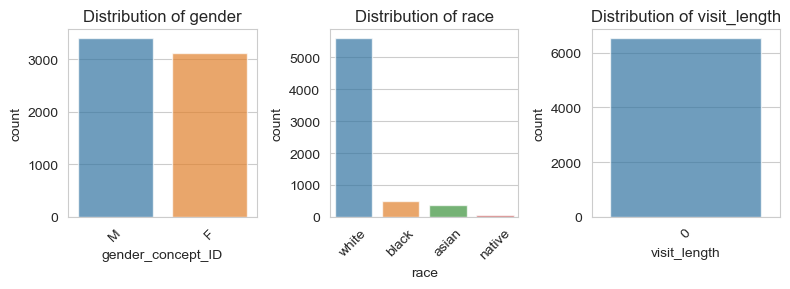

In [44]:
#create bar plot for gender, race and visit_length
cat_col = ['gender_concept_ID', 'race', 'visit_length']
df_cat = clean_df[cat_col]

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
titles = ['Distribution of gender', 'Distribution of race', 'Distribution of visit_length']

for i, ax in enumerate(fig.axes):
    if i < len(df_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_cat.columns[i], alpha=0.7, data=df_cat, ax=ax)
        ax.set_title(titles[i])

fig.tight_layout()

## making Box-Plot

In [45]:
select_columns = df_merged.columns[16:]
all_nan_row = df_merged[df_merged[selected_columns].isna().all(axis=1)]
box_plot_df = exclusive1_df.drop(all_nan_row.index)

In [46]:
box_df = pd.merge(box_plot_df, omop_visit[['visit_occurrence_id', 'admitted_from_concept_id', 'discharged_to_concept_id']], on='visit_occurrence_id', how='left')
box_df = pd.merge(box_df, omop_concept[['concept_id', 'concept_name']], 
                     left_on='admitted_from_concept_id', 
                     right_on='concept_id', 
                     how='left').rename(columns={'concept_name_y': 'admitted_from'})

box_df = pd.merge(box_df, omop_concept[['concept_id', 'concept_name']], 
                     left_on='discharged_to_concept_id', 
                     right_on='concept_id', 
                     how='left').rename(columns={'concept_name': 'discharged_to'})
box_df = box_df.drop(columns=['concept_id_x', 'concept_id_y'])
box_df.head(10)

,person_id,visit_occurrence_id,visit_start_date,visit_end_date,visit_start_datetime,visit_end_datetime,birth_datetime,current_age,gender_concept_ID,race,...,Weight-for-length Per age and sex,Wheat IgE Ab [Units/volume] in Serum,White Oak IgE Ab [Units/volume] in Serum,pH of Arterial blood,pH of Urine by Test strip,visit_number,admitted_from_concept_id,discharged_to_concept_id,admitted_from,discharged_to
0,12,556,2012-11-28,2012-11-28,2012-11-28,2012-11-28,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,28,0,0,No matching concept,No matching concept
1,12,555,2013-12-04,2013-12-04,2013-12-04,2013-12-04,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,29,0,0,No matching concept,No matching concept
2,12,570,2014-12-10,2014-12-10,2014-12-10,2014-12-10,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,30,0,0,No matching concept,No matching concept
3,12,576,2015-12-16,2015-12-16,2015-12-16,2015-12-16,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,31,0,0,No matching concept,No matching concept
4,12,549,2016-12-21,2016-12-21,2016-12-21,2016-12-21,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,33,0,0,No matching concept,No matching concept
5,12,550,2017-12-27,2017-12-27,2017-12-27,2017-12-27,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,34,0,0,No matching concept,No matching concept
6,12,560,2019-01-02,2019-01-02,2019-01-02,2019-01-02,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,36,0,0,No matching concept,No matching concept
7,12,566,2020-01-08,2020-01-08,2020-01-08,2020-01-08,1968-05-08,55,M,white,...,NaN,NaN,NaN,NaN,NaN,37,0,0,No matching concept,No matching concept
8,18,817,2012-12-03,2012-12-03,2012-12-03,2012-12-03,1968-11-18,54,M,white,...,NaN,NaN,NaN,NaN,NaN,3,0,0,No matching concept,No matching concept
9,18,825,2014-02-05,2014-02-05,2014-02-05,2014-02-05,1968-11-18,54,M,white,...,NaN,NaN,NaN,NaN,NaN,4,0,0,No matching concept,No matching concept


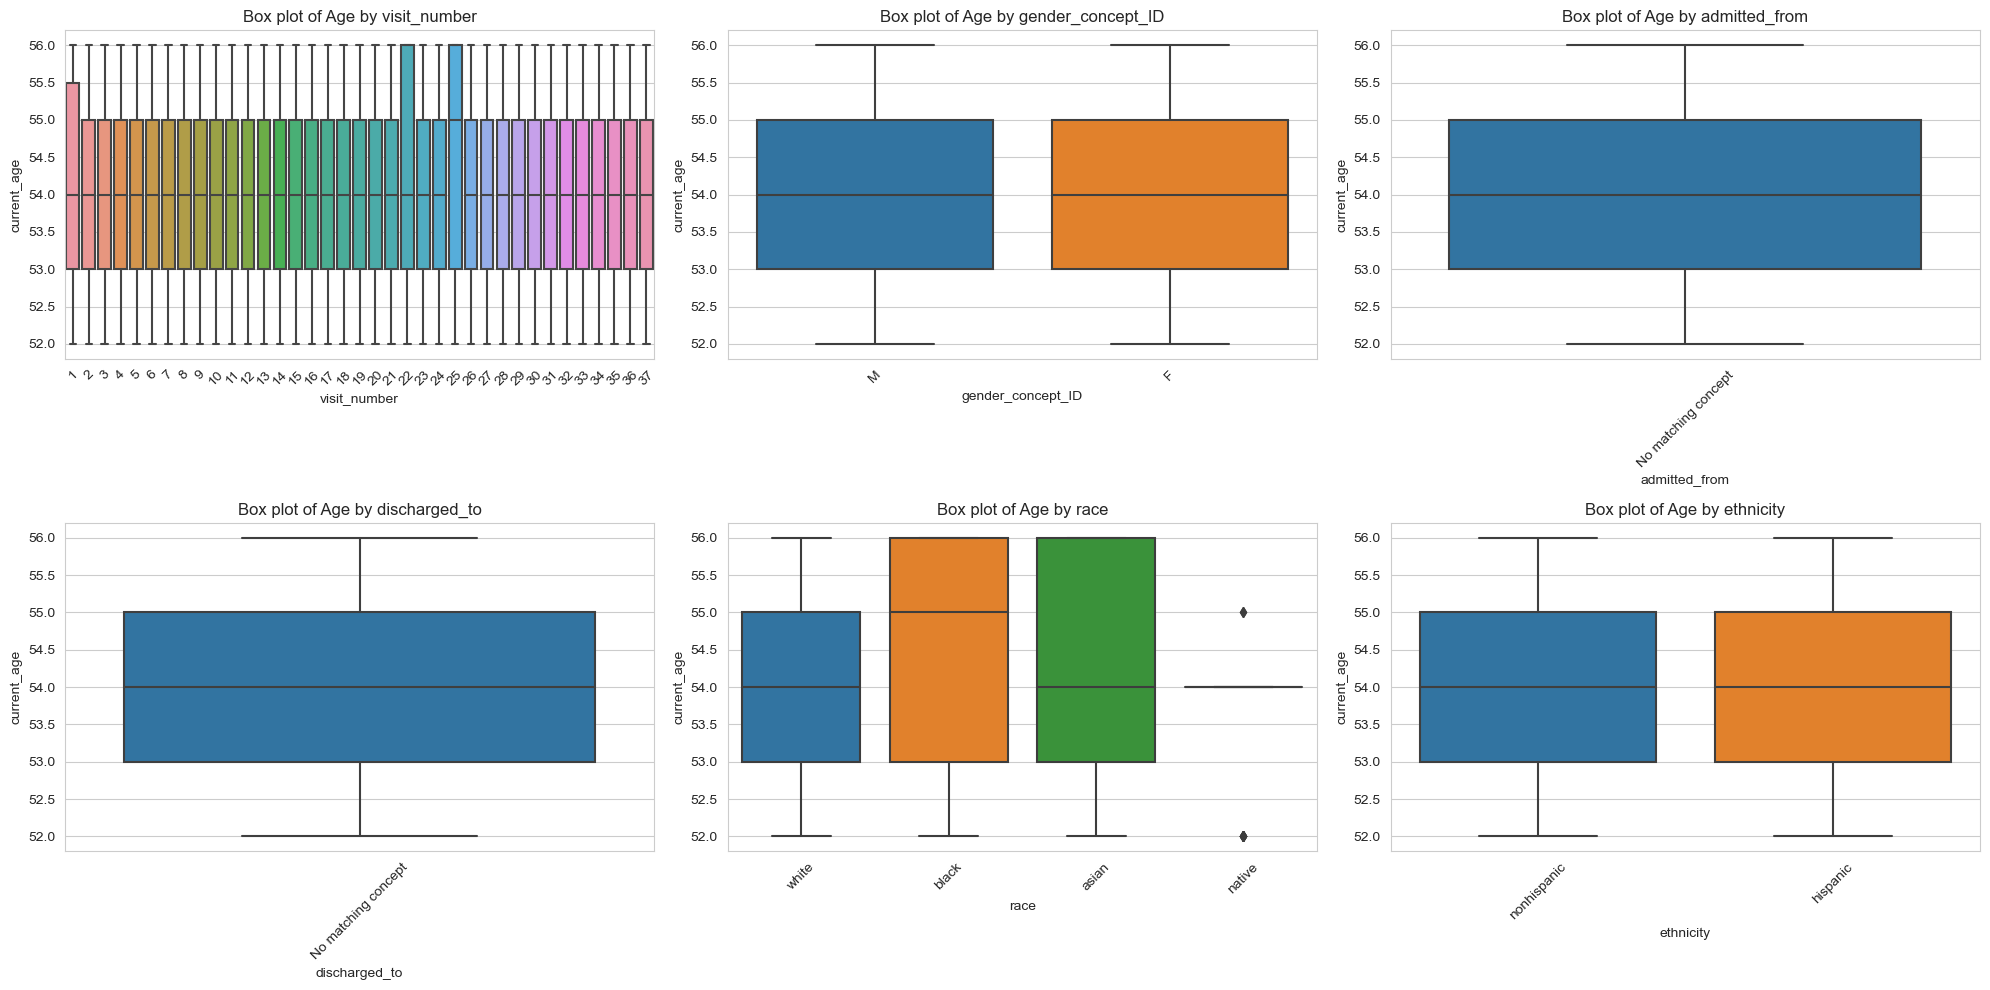

In [47]:
cat_cols = ['visit_number', 'gender_concept_ID', 'admitted_from', 'discharged_to', 'race', 'ethnicity']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for i, cat in enumerate(cat_cols):
    ax = sns.boxplot(x=cat, y='current_age', data=box_df, ax=axes[i])
    ax.set_title(f'Box plot of Age by {cat}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
fig.tight_layout()
plt.show()